In [1]:
import os
import pickle
from operator import itemgetter
import json
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm 
from PIL import Image
from transformers import pipeline
from models.vit import ViTForClassification
import torch
from torch.utils.data import Dataset

In [2]:
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]
    
def load_config(config_path: str) -> dict:
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

def load_model(
    model_path: str, config_path: str, device: torch.device
) :
    if device.type == "cpu":
        checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    else:
        checkpoint = torch.load(model_path)
    config = load_config(config_path)
    model = ViTForClassification(config)
    model.load_state_dict(checkpoint)
    return model.to(device), config

def load_raw_images(img_dir: str):
    """
    Load images from a directory, convert them to grayscale, resize to 28x28, and apply a standard transformation.

    Args:
        img_dir: The directory from which images are loaded.

    Returns:
        A tuple containing a batch of tensor images and their corresponding names.
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]
    )
    image_extensions = (".jpg", ".jpeg", ".png", ".gif", ".bmp")
    images = []
    images_names = []
    for filename in os.listdir(img_dir):
        if os.path.isfile(
            os.path.join(img_dir, filename)
        ) and filename.lower().endswith(image_extensions):
            image = Image.open(os.path.join(img_dir, filename)).convert("L")
            if image.size != (28, 28):
                image = image.resize((28, 28))
            images.append(transform(image))
            images_names.append(filename.split(".")[0])
    return torch.stack(images), images_names

def load_raw_sents(txt_dir: str):
    txts = []
    txts_names = []
    for filename in os.listdir(txt_dir):
        if os.path.isfile(
            os.path.join(txt_dir, filename)
        ) and filename.lower().endswith(".txt"):
            with open(os.path.join(txt_dir, filename), "r", encoding="utf-8") as file:
                txts.append(file.readlines()[0])
            txts_names.append(filename.split(".")[0])
    return txts, txts_names

In [3]:
res_path = "/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/res/1-sqrtmax-2-sqrtmax/input-space-exploration"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
cl_map = {'LABEL_0': 'neutral', 'LABEL_1': 'offensive', 'LABEL_2': 'hate'}
cls_pipe = pipeline("text-classification", model="ctoraman/hate-speech-bert")
msk_pipe = pipeline("fill-mask", model = "bert-base-uncased")

/Users/lizzy/.pyenv/versions/3.10.9/envs/input-space-inspection/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

# Count how many times predictions changes (comparing iteration 0 to iteration 1000)

In [39]:
def count_changes(folders):
    experiments = {"has_changed":[], "experiment_name":[]}
    for folder in folders:
        exp_name = " ".join(folder.split(os.path.sep)[-1].split("-")[:3])
        for exp in os.listdir(folder):
            if os.path.isdir(os.path.join(folder, exp)) and os.path.exists(
                    os.path.join(folder, exp, "pred-stats.json")
                ):
                for interpretation_dir in os.listdir(os.path.join(folder, exp)):
                    if os.path.isdir(os.path.join(folder, exp, interpretation_dir)):
                        for interpretation_res in os.listdir(os.path.join(folder, exp, interpretation_dir)):
                            if interpretation_res.startswith("0-") and (interpretation_res.endswith(".txt") or interpretation_res.endswith(".png")):
                                pred_0 = interpretation_res.split("-")[2]
                            if interpretation_res.startswith("1000-") and (interpretation_res.endswith(".txt") or interpretation_res.endswith(".png")):
                                pred_1000 = interpretation_res.split("-")[2]
                            try:
                                experiments["has_changed"].append(int(pred_1000 != pred_0))
                                experiments["experiment_name"].append(exp_name)
                            except UnboundLocalError:
                                pass # for whatever reasons there is one experiment not concluding at iteration 1000
    return experiments
                    

In [40]:
res_dirs = [os.path.join(res_path, d) for d in os.listdir(res_path) if d.startswith("sime")]
experiments = count_changes(res_dirs)
pd.DataFrame.from_dict(experiments).groupby("experiment_name").mean("has_changed")

,has_changed
experiment_name,
simec bert cls,0.137823
simec bert msk,0.467516
simec vit 1,0.524752
simexp bert cls,0.091546
simexp bert msk,0.312500
simexp vit 1,0.495346


## At which iteration there's a change?

In [171]:
def load_predictions(folders):
    predictions = {"iteration":[],"experiment_name":[], "prediction":[], "name":[]}
    for folder in folders:
        if "vit" in folder:
            exp_name = " ".join(folder.split(os.path.sep)[-1].split("-")[:2])
        else:
            exp_name = " ".join(folder.split(os.path.sep)[-1].split("-")[:3])
        for exp in os.listdir(folder):
            if os.path.isdir(os.path.join(folder, exp)) and os.path.exists(
                    os.path.join(folder, exp, "pred-stats.json")
                ):
                for interpretation_dir in os.listdir(os.path.join(folder, exp)):
                    if os.path.isdir(os.path.join(folder, exp, interpretation_dir)):
                        for interpretation_res in os.listdir(os.path.join(folder, exp, interpretation_dir)):
                            if interpretation_res.endswith(".txt") or interpretation_res.endswith(".png"):
                                predictions["iteration"].append(int(interpretation_res.split('-')[0]))
                                predictions["experiment_name"].append(exp_name)
                                try:
                                    predictions["prediction"].append(int(interpretation_res.split("-")[-1].split(".")[0]))
                                except:
                                    predictions["prediction"].append(interpretation_res.split("-")[-1].split(".")[0].lower())
                                predictions["name"].append(exp)

    return predictions

In [172]:
vit_model, _ = load_model(
    model_path="/Users/lizzy/research/input-space-inspection/models/vit/model_20.pt",
    config_path="/Users/lizzy/research/input-space-inspection/models/vit/config.json",
    device=device,
)
vit_model = vit_model.to(device)
vit_model.eval()

images, img_names = load_raw_images("/Users/lizzy/research/input-space-inspection/data/MNIST/MNIST/images")
vit_preds = {k:p for k, p in zip(img_names, torch.argmax(vit_model(images)[0], dim = -1))}
msk_txts, msk_names = load_raw_sents("/Users/lizzy/research/input-space-inspection/data/MLM-BERT/sentences")
msk_txts = [sent.replace("[CLS]","").replace("[SEP]","") for sent in msk_txts]
msk_preds = {k:p for k, p in zip(msk_names, msk_pipe(msk_txts))}
cls_txts, cls_names = load_raw_sents("/Users/lizzy/research/input-space-inspection/data/CLS-BERT/hate-speech")
cls_txts = [sent.replace("[CLS]","").replace("[SEP]","") for sent in cls_txts]
cls_preds = {k:p for k, p in zip(cls_names, cls_pipe(cls_txts))}

In [173]:
predictions = pd.DataFrame.from_dict(load_predictions(res_dirs))
predictions["post_pred"] = None

In [174]:
for index, row in predictions.iterrows():
    if "vit" in predictions.loc[index,"experiment_name"]:
        predictions.loc[index,"post_pred"] = vit_preds[predictions.loc[index,"name"]].item()
    if "cls" in predictions.loc[index,"experiment_name"]:
        predictions.loc[index,"post_pred"] = cl_map[cls_preds[predictions.loc[index,"name"]]["label"]]
    if "msk" in predictions.loc[index,"experiment_name"]:
        predictions.loc[index,"post_pred"] = msk_preds[predictions.loc[index,"name"]][0]["token_str"]

In [175]:
predictions["has_changed"] = predictions["prediction"] != predictions["post_pred"]

In [176]:
exp_vit = predictions.loc[predictions["experiment_name"].str.contains("vit")]
exp_bert_cls = predictions.loc[predictions["experiment_name"].str.contains("cls")]
exp_bert_msk = predictions.loc[predictions["experiment_name"].str.contains("msk")]

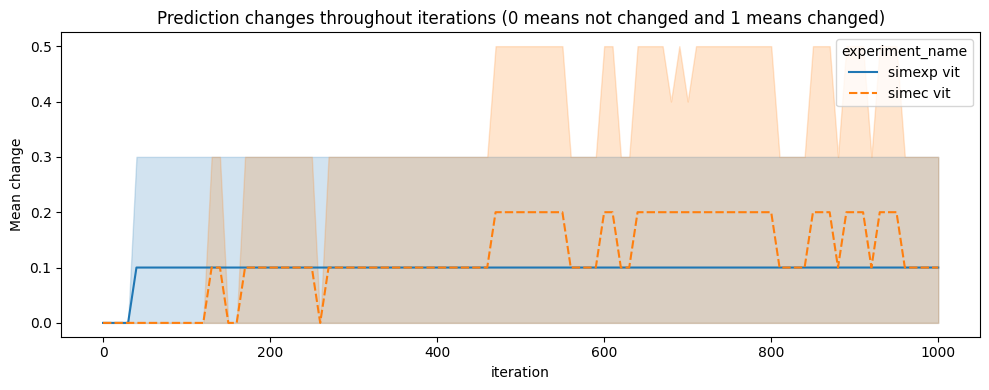

In [178]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=1)
sns.lineplot(data=exp_vit, ax=ax, x = "iteration", y = "has_changed", style = "experiment_name", hue = "experiment_name")
ax.set(ylabel='Mean change', title = 'Prediction changes throughout iterations (0 means not changed and 1 means changed)')
plt.tight_layout()
plt.show()

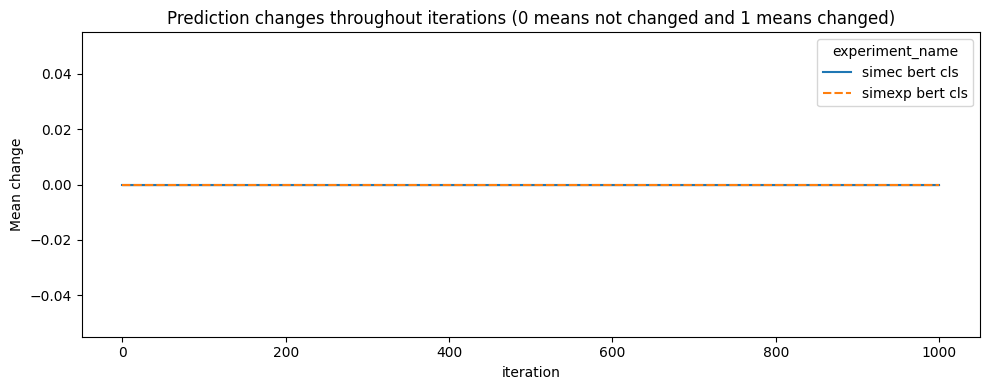

In [179]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=1)
sns.lineplot(data=exp_bert_cls, ax=ax, x = "iteration", y = "has_changed", style = "experiment_name", hue = "experiment_name")
ax.set(ylabel='Mean change', title = 'Prediction changes throughout iterations (0 means not changed and 1 means changed)')
plt.tight_layout()
plt.show()

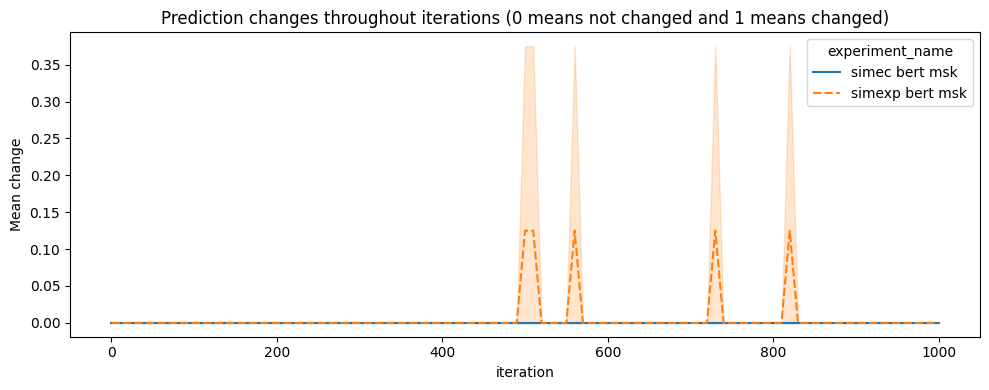

In [180]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=1)
sns.lineplot(data=exp_bert_msk, ax=ax, x = "iteration", y = "has_changed", style = "experiment_name", hue = "experiment_name")
ax.set(ylabel='Mean change', title = 'Prediction changes throughout iterations (0 means not changed and 1 means changed)')
plt.tight_layout()
plt.show()

# Prompting verification

In [141]:
def collect_data(res_dir, objective, pipe, cls_map = None):
    data = {"original-sentence": [], "original-pred":[], "original-pred-proba":[], "algorithm":[],"iteration":[],"explore-token":[],"alternative-token":[],"alternative-token-proba":[],"alternative-pred":[],"alternative-pred-proba":[]}
    selected_dirs = [d for d in os.listdir(res_dir) if objective in d and os.path.isdir(os.path.join(res_dir,d))]
    for exp_dir in selected_dirs:
        for res in tqdm(os.listdir(os.path.join(res_dir, exp_dir)), desc = exp_dir):
            if os.path.isdir(os.path.join(res_dir, exp_dir, res)):
                files = [
                    filename
                    for filename in os.listdir(
                        os.path.join(res_dir, exp_dir, res, "interpretation")
                    )
                    if os.path.isfile(
                        os.path.join(res_dir, exp_dir, res, "interpretation", filename)
                    )
                    and filename.lower().endswith("-stats.json")
                ]
                original_pred = None
                for j_file in tqdm(files, desc = res):
                    stats = json.load(
                        open(
                            os.path.join(res_dir, exp_dir, res, "interpretation", j_file), "r"
                        )
                    )
                    eq_class_wrds_keys = [
                        k
                        for k in stats.keys()
                        if "cap-probas-" in k
                        and "pre-cap-probas-" not in k
                        and k != "cap-probas-mod"
                    ]
                    if original_pred is None:
                        original_pred = pipe(" ".join(stats["original-sentence"][1:-1]))[0]
                    for word in eq_class_wrds_keys:                    
                        for alternative in stats[word]:
                            data["original-sentence"].append(" ".join(stats["original-sentence"][1:-1]))
                            try:
                                data["original-pred"].append(cls_map[original_pred['label']])
                            except KeyError:
                                data["original-pred"].append(original_pred['token_str'])
                            data["original-pred-proba"].append(original_pred['score'])
                            data["algorithm"].append(exp_dir.split("-")[0])
                            data["iteration"].append(j_file.split("-")[0])
                            data["explore-token"].append(word.split("-")[-1])
                            data["alternative-token"].append(alternative[0])
                            data["alternative-token-proba"].append(alternative[1])
                            # Compute modified sentence prediction
                            word_index = stats["original-sentence"].index(word.split("-")[-1])
                            mod_sentence = " ".join((stats["original-sentence"][1:word_index] + [alternative[0]] + stats["original-sentence"][word_index + 1:-1]))
                            alternative_pred = pipe(mod_sentence)[0]
                            try:
                                data["alternative-pred"].append(cls_map[alternative_pred['label']])
                            except KeyError:
                                data["alternative-pred"].append(alternative_pred['token_str'])
                            data["alternative-pred-proba"].append(alternative_pred['score'])
    return data 
                    

In [142]:
data_cls = pd.DataFrame.from_dict(collect_data(res_path, "cls", cls_pipe, cl_map))
data_cls["same-eq-class"] = data_cls["original-pred"] == data_cls["alternative-pred"]
data_cls["iteration"] = data_cls["iteration"].astype(int)
#data_cls.to_csv(os.path.join(res_path, "bert-cls.csv"), index = False)

simec-bert-cls-1-sqrtmax-1-sqrtmax-capend-20240516-175838:   0%|          | 0/13 [00:00<?, ?it/s]

sentence_7:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_6:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_10:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_11:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_4:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_5:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_2:   0%|          | 0/40 [00:00<?, ?it/s]

sentence_37:   0%|          | 0/101 [00:00<?, ?it/s]

simexp-bert-cls-1-sqrtmax-1-sqrtmax-capend-20240517-075559:   0%|          | 0/13 [00:00<?, ?it/s]

sentence_7:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_6:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_10:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_11:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_4:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_5:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_2:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_37:   0%|          | 0/101 [00:00<?, ?it/s]

In [143]:
data_msk = pd.DataFrame.from_dict(collect_data(res_path, "msk", msk_pipe))
data_msk["same-eq-class"] = data_msk["original-pred"] == data_msk["alternative-pred"]
data_msk["iteration"] = data_msk["iteration"].astype(int)
#data_msk.to_csv(os.path.join(res_path, "bert-msk.csv"), index = False)

simec-bert-msk-1-sqrtmax-1-sqrtmax-capend-20240515-140306:   0%|          | 0/14 [00:00<?, ?it/s]

sentence_9:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_8:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_28:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_45:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_100:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_3:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_5:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_63:   0%|          | 0/101 [00:00<?, ?it/s]

simexp-bert-msk-1-sqrtmax-1-sqrtmax-capend-20240516-041403:   0%|          | 0/14 [00:00<?, ?it/s]

sentence_9:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_8:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_28:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_45:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_100:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_3:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_5:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_63:   0%|          | 0/101 [00:00<?, ?it/s]

In [164]:
data_cls = pd.read_csv(os.path.join(res_path, "bert-cls.csv"))
data_msk = pd.read_csv(os.path.join(res_path, "bert-msk.csv"))

In [165]:
data_cls = data_cls.loc[data_cls["original-sentence"] != "he went to the store to pick up groceries ."]

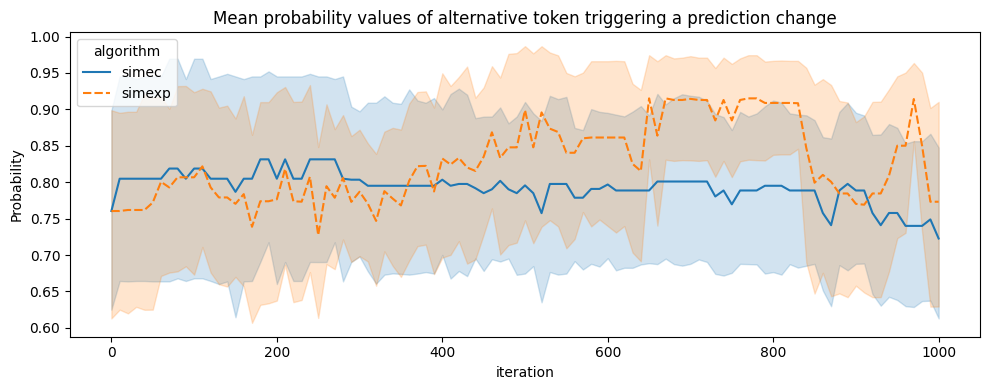

In [166]:
plot_data = data_cls.loc[data_cls["same-eq-class"] == False]#.groupby(["algorithm","iteration","same-eq-class"], as_index=False)#.mean("alternative-pred-proba")
fig, ax = plt.subplots(figsize=(10, 4), ncols=1)
sns.lineplot(data=plot_data, ax=ax, x = "iteration", y = "alternative-pred-proba", style = "algorithm", hue = "algorithm")
ax.set(ylabel='Probability', title = 'Mean probability values of alternative token triggering a prediction change')
plt.tight_layout()
plt.show()

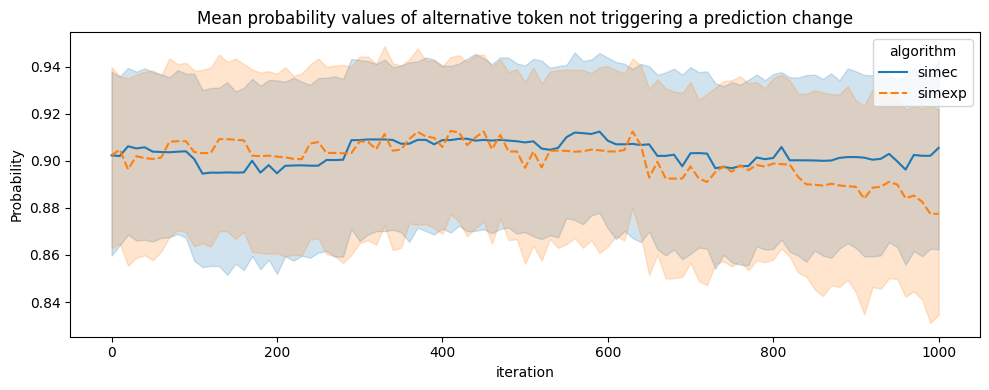

In [167]:
plot_data = data_cls.loc[data_cls["same-eq-class"] == True]#.groupby(["algorithm","iteration","same-eq-class"], as_index=False)#.mean("alternative-pred-proba")
fig, ax = plt.subplots(figsize=(10, 4), ncols=1)
sns.lineplot(data=plot_data, ax=ax, x = "iteration", y = "alternative-pred-proba", style = "algorithm", hue = "algorithm")
ax.set(ylabel='Probability', title = 'Mean probability values of alternative token not triggering a prediction change')
plt.tight_layout()
plt.show()

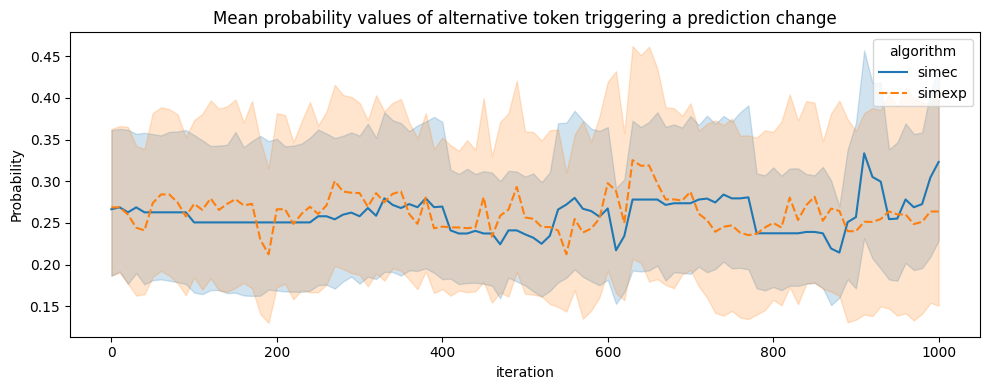

In [168]:
plot_data = data_msk[data_msk["same-eq-class"] == False]#.groupby(["algorithm","iteration","same-eq-class"], as_index=False).mean("alternative-pred-proba")
fig, ax = plt.subplots(figsize=(10, 4), ncols=1)
sns.lineplot(data=plot_data, ax=ax, x = "iteration", y = "alternative-pred-proba", style = "algorithm", hue = "algorithm")
ax.set(ylabel='Probability', title = 'Mean probability values of alternative token triggering a prediction change')
plt.tight_layout()
plt.show()

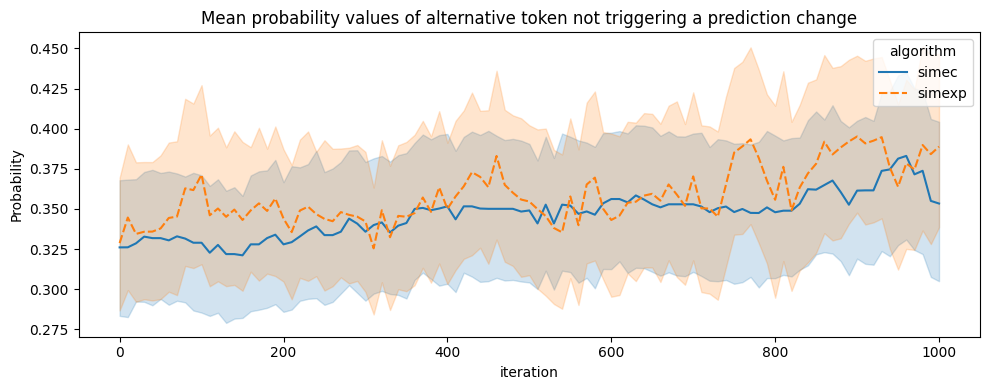

In [169]:
plot_data = data_msk[data_msk["same-eq-class"] == True]#.groupby(["algorithm","iteration","same-eq-class"], as_index=False).mean("alternative-pred-proba")
fig, ax = plt.subplots(figsize=(10, 4), ncols=1)
sns.lineplot(data=plot_data, ax=ax, x = "iteration", y = "alternative-pred-proba", style = "algorithm", hue = "algorithm")
ax.set(ylabel='Probability', title = 'Mean probability values of alternative token not triggering a prediction change')
plt.tight_layout()
plt.show()

# Comparing pre- and post- prediction scores for equivalence class label

In [50]:
def collect_data_no_pred(res_dir, objective, original_preds = None, pipe = None):
    if pipe:
        data = {"file-name":[],"original-sentence": [], "mod-sentence":[],"original-pred":[], "original-pred-proba":[], "algorithm":[],"iteration":[],"explore-token":[],"alternative-token":[],"alternative-token-proba":[],"modified-pred-proba":[]}
    else:
        data = {"file-name":[], "original-pred":[],"algorithm":[],"iteration":[],"modified-pred-proba":[], "modified-pred":[],"modified-original-proba":[]}
    selected_dirs = [d for d in os.listdir(res_dir) if objective in d and os.path.isdir(os.path.join(res_dir,d))]
    for exp_dir in selected_dirs:
        for res in tqdm(os.listdir(os.path.join(res_dir, exp_dir)), desc = exp_dir):
            if os.path.isdir(os.path.join(res_dir, exp_dir, res)):
                files = [
                    filename
                    for filename in os.listdir(
                        os.path.join(res_dir, exp_dir, res, "interpretation")
                    )
                    if os.path.isfile(
                        os.path.join(res_dir, exp_dir, res, "interpretation", filename)
                    )
                    and filename.lower().endswith("-stats.json")
                ]
                for j_file in tqdm(files, desc = res):
                    stats = json.load(
                        open(
                            os.path.join(res_dir, exp_dir, res, "interpretation", j_file), "r"
                        )
                    )
                    if pipe:
                        eq_class_wrds_keys = [
                            k
                            for k in stats.keys()
                            if "cap-probas-" in k
                            and "pre-cap-probas-" not in k
                            and k != "cap-probas-mod"
                        ]
                        for word in eq_class_wrds_keys:                    
                            for alternative in stats[word]:
                                data["original-sentence"].append(" ".join(stats["original-sentence"][1:-1]))
                                data["algorithm"].append(exp_dir.split("-")[0])
                                data["iteration"].append(int(j_file.split("-")[0]))
                                data["explore-token"].append(word.split("-")[-1])
                                data["alternative-token"].append(alternative[0])
                                data["alternative-token-proba"].append(alternative[1])
                                # Compute modified sentence prediction
                                word_index = stats["original-sentence"].index(word.split("-")[-1])
                                mod_sentence = " ".join((stats["original-sentence"][1:word_index] + [alternative[0]] + stats["original-sentence"][word_index + 1:-1]))
                                data["mod-sentence"].append(mod_sentence)
                                data["file-name"].append(res)
                                if objective == "msk":
                                    data["original-pred"].append(original_preds[res]['token_str'])
                                    alternative_pred = pipe(mod_sentence, targets = [original_preds[res]['token_str']])[0]
                                else:
                                    data["original-pred"].append(original_preds[res]['label'])
                                    alternative_pred = pipe(mod_sentence, return_all_scores = True)[0]
                                    alternative_pred = [d for d in alternative_pred if d["label"] == original_preds[res]['label']][0]
                                
                                data["modified-pred-proba"].append(alternative_pred['score'])
                                data["original-pred-proba"].append(original_preds[res]['score'])
                    else:
                        data["file-name"].append(res)
                        data["original-pred"].append(stats["original_image_pred"])
                        data["modified-pred-proba"].append(stats["modified_image_pred_proba"])
                        data["modified-original-proba"].append(stats["modified_original_pred_proba"])
                        data["modified-pred"].append(stats["modified_image_pred"])
                        data["algorithm"].append(exp_dir.split("-")[0])
                        data["iteration"].append(int(j_file.split("-")[0]))
    return data 
                    

In [7]:
msk_txts, msk_names = load_raw_sents("/Users/lizzy/research/input-space-inspection/data/MLM-BERT/sentences")
msk_txts = [sent.replace("[CLS]","").replace("[SEP]","") for sent in msk_txts]
msk_preds = {k:p[0] for k, p in zip(msk_names, msk_pipe(msk_txts))}
cls_txts, cls_names = load_raw_sents("/Users/lizzy/research/input-space-inspection/data/CLS-BERT/hate-speech")
cls_txts = [sent.replace("[CLS]","").replace("[SEP]","") for sent in cls_txts]
cls_preds = {k:p for k, p in zip(cls_names, cls_pipe(cls_txts))}

In [14]:
data_cls = pd.DataFrame.from_dict(collect_data_no_pred(res_path, "cls", cls_preds, cls_pipe))
data_cls = data_cls.loc[data_cls["file-name"] != "sentence_2"]
data_cls["original-pred"] = data_cls["original-pred"].apply(lambda a: cl_map[a])
other_data_cls = pd.read_csv(os.path.join(res_path, "bert-cls.csv"))
data_cls = data_cls.merge(other_data_cls, how = "left", on=["original-sentence", "algorithm","explore-token","alternative-token","iteration", "original-pred", "original-pred-proba","alternative-token-proba"])
data_cls.to_csv(os.path.join(res_path, "bert-cls-eq-class-proba.csv"), index = False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [103]:
data_vit = pd.DataFrame.from_dict(collect_data_no_pred(res_path, "vit"))
data_vit = data_vit.loc[data_vit["file-name"] != "img_34"]
data_vit["same-eq-class"] = data_vit["original-pred"] == data_vit["modified-pred"]
data_vit.to_csv(os.path.join(res_path, "vit-eq-class-proba.csv"), index = False)

simec-vit-20240520-231028:   0%|          | 0/18 [00:00<?, ?it/s]

img_6295:   0%|          | 0/101 [00:00<?, ?it/s]

img_6861:   0%|          | 0/101 [00:00<?, ?it/s]

img_4768:   0%|          | 0/101 [00:00<?, ?it/s]

img_8511:   0%|          | 0/101 [00:00<?, ?it/s]

img_6273:   0%|          | 0/101 [00:00<?, ?it/s]

img_6738:   0%|          | 0/101 [00:00<?, ?it/s]

img_9783:   0%|          | 0/101 [00:00<?, ?it/s]

img_757:   0%|          | 0/101 [00:00<?, ?it/s]

img_1938:   0%|          | 0/101 [00:00<?, ?it/s]

img_9792:   0%|          | 0/101 [00:00<?, ?it/s]

img_7662:   0%|          | 0/101 [00:00<?, ?it/s]

img_7361:   0%|          | 0/101 [00:00<?, ?it/s]

img_1453:   0%|          | 0/101 [00:00<?, ?it/s]

img_4860:   0%|          | 0/101 [00:00<?, ?it/s]

simexp-vit-20240521-002247:   0%|          | 0/18 [00:00<?, ?it/s]

img_6295:   0%|          | 0/101 [00:00<?, ?it/s]

img_6861:   0%|          | 0/101 [00:00<?, ?it/s]

img_4768:   0%|          | 0/101 [00:00<?, ?it/s]

img_8511:   0%|          | 0/101 [00:00<?, ?it/s]

img_6273:   0%|          | 0/101 [00:00<?, ?it/s]

img_6738:   0%|          | 0/101 [00:00<?, ?it/s]

img_9783:   0%|          | 0/101 [00:00<?, ?it/s]

img_757:   0%|          | 0/101 [00:00<?, ?it/s]

img_1938:   0%|          | 0/101 [00:00<?, ?it/s]

img_9792:   0%|          | 0/101 [00:00<?, ?it/s]

img_7662:   0%|          | 0/101 [00:00<?, ?it/s]

img_7361:   0%|          | 0/101 [00:00<?, ?it/s]

img_1453:   0%|          | 0/101 [00:00<?, ?it/s]

img_4860:   0%|          | 0/101 [00:00<?, ?it/s]

In [38]:
data_msk = pd.DataFrame.from_dict(collect_data_no_pred(res_path, "msk", msk_preds, msk_pipe))
other_data_msk = pd.read_csv(os.path.join(res_path, "bert-msk.csv"))
data_msk = data_msk.merge(other_data_msk, how = "left", on=["original-sentence", "algorithm","explore-token","alternative-token","iteration", "original-pred", "original-pred-proba","alternative-token-proba"])
data_msk.to_csv(os.path.join(res_path, "bert-msk-eq-class-proba.csv"), index = False)

simec-bert-msk-1-sqrtmax-1-sqrtmax-capend-20240515-140306:   0%|          | 0/14 [00:00<?, ?it/s]

sentence_9:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_8:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_28:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_45:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_100:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_3:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_5:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_63:   0%|          | 0/101 [00:00<?, ?it/s]

simexp-bert-msk-1-sqrtmax-1-sqrtmax-capend-20240516-041403:   0%|          | 0/14 [00:00<?, ?it/s]

sentence_9:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_8:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_28:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_45:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_100:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_3:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_5:   0%|          | 0/101 [00:00<?, ?it/s]

sentence_63:   0%|          | 0/101 [00:00<?, ?it/s]

In [98]:
palette = {"simec":"cornflowerblue", "simexp":"darkorange"}
style = {"simec":"", "simexp":(3,2)}

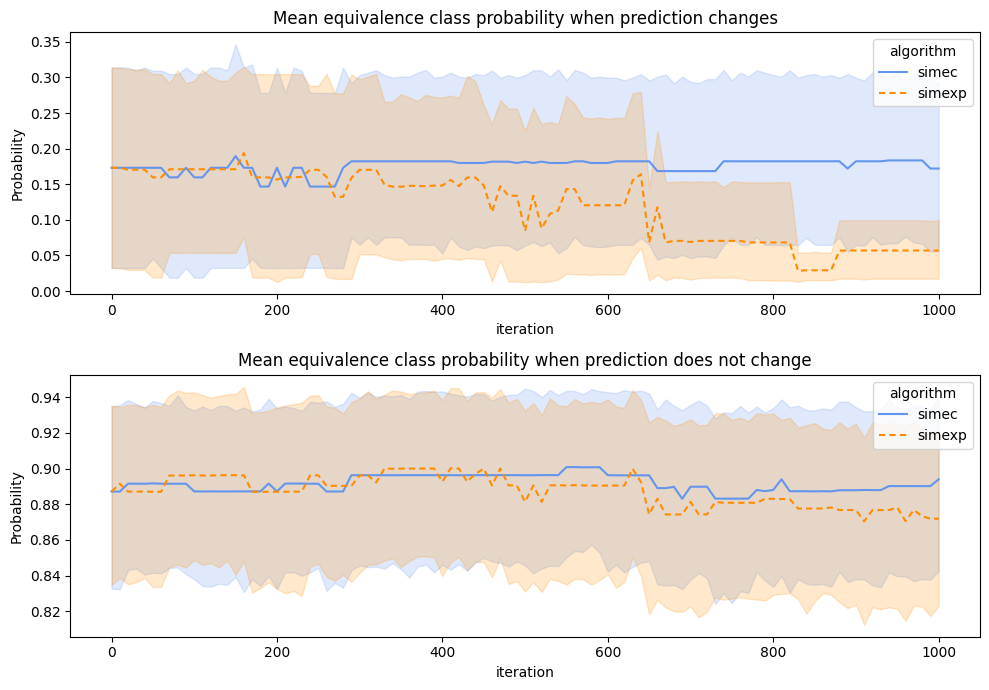

In [99]:
fig, ax = plt.subplots(figsize=(10, 7), nrows=2)
sns.lineplot(data=data_cls.loc[data_cls["same-eq-class"] == False], ax=ax[0], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[0].set(ylabel='Probability', title = 'Mean equivalence class probability when prediction changes')
sns.lineplot(data=data_cls.loc[data_cls["same-eq-class"] == True], ax=ax[1], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[1].set(ylabel='Probability', title = 'Mean equivalence class probability when prediction does not change')
plt.tight_layout()
plt.show()

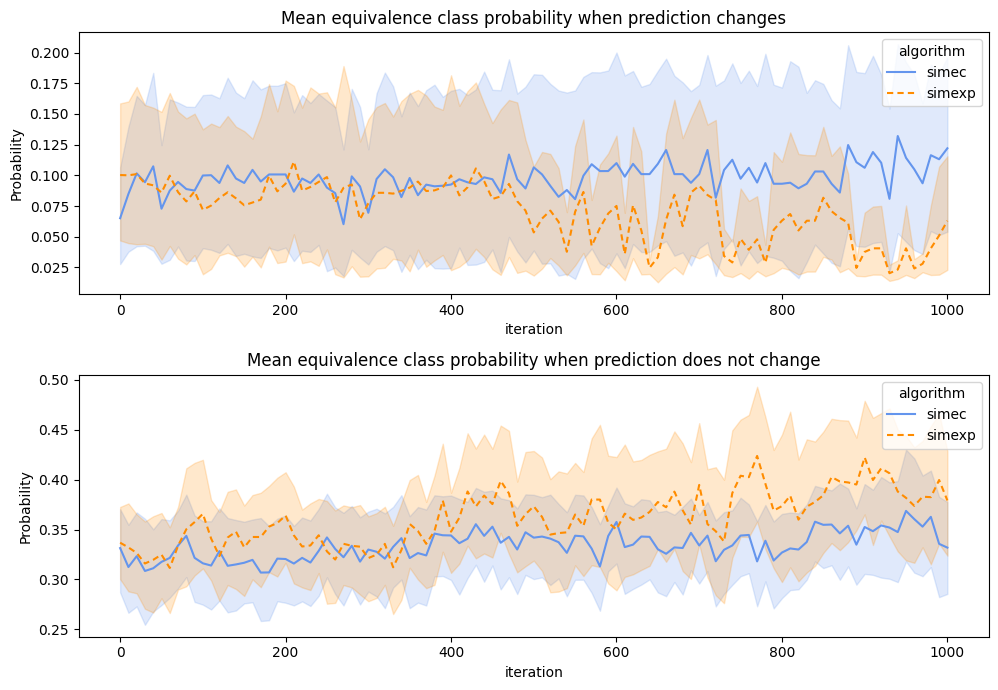

In [100]:
fig, ax = plt.subplots(figsize=(10, 7), nrows=2)
data_msk = data_msk.dropna()
sns.lineplot(data=data_msk.loc[data_msk["same-eq-class"] == False], ax=ax[0], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[0].set(ylabel='Probability', title = 'Mean equivalence class probability when prediction changes')
sns.lineplot(data=data_msk.loc[data_msk["same-eq-class"] == True], ax=ax[1], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[1].set(ylabel='Probability', title = 'Mean equivalence class probability when prediction does not change')
plt.tight_layout()
plt.show()

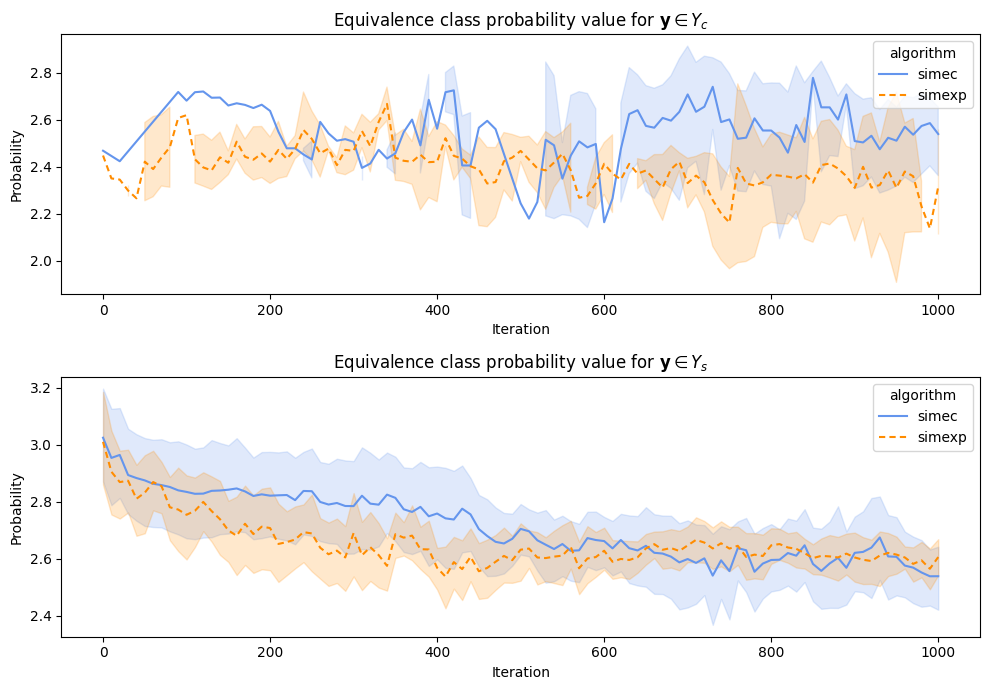

In [108]:
fig, ax = plt.subplots(figsize=(10, 7), nrows=2)
sns.lineplot(data=data_vit.loc[data_vit["same-eq-class"] == False], ax=ax[0], x = "iteration", y = "modified-original-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[0].set(ylabel='Probability', title = 'Equivalence class probability value for $\mathbf{y} \in Y_c$', xlabel = "Iteration")
sns.lineplot(data=data_vit.loc[data_vit["same-eq-class"] == True], ax=ax[1], x = "iteration", y = "modified-original-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[1].set(ylabel='Probability', title = 'Equivalence class probability value for $\mathbf{y} \in Y_s$', xlabel = "Iteration")
plt.tight_layout()
plt.show()

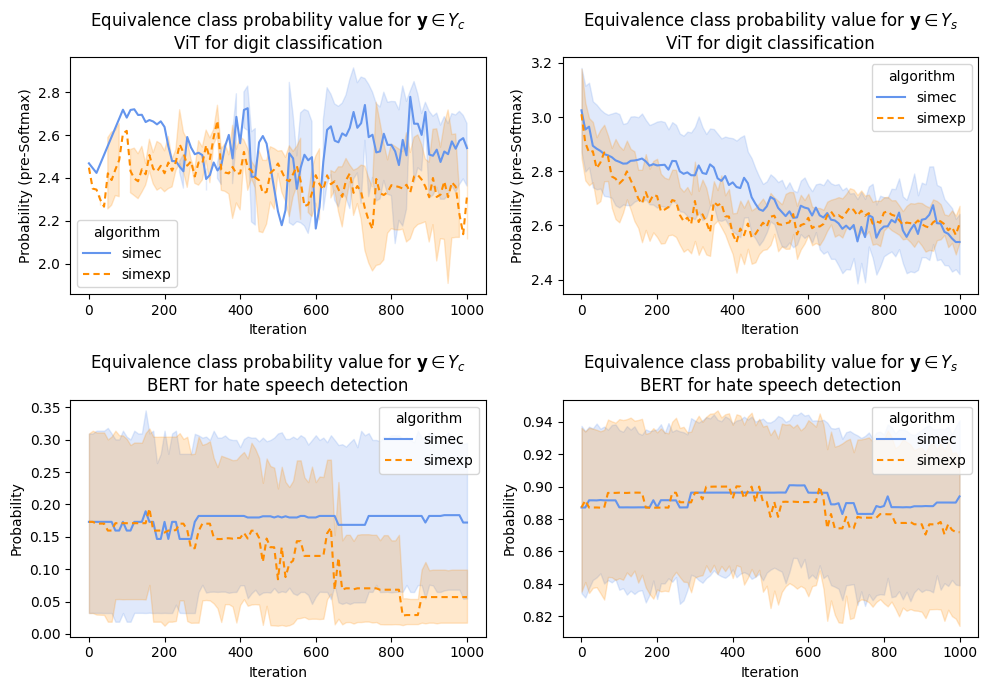

In [126]:
fig, ax = plt.subplots(figsize=(10, 7), nrows=2, ncols = 2)
sns.lineplot(data=data_cls.loc[data_cls["same-eq-class"] == False], ax=ax[1][0], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[1][0].set(ylabel='Probability', title = 'Equivalence class probability value for $\mathbf{y} \in Y_c$\nBERT for hate speech detection', xlabel = "Iteration")
sns.lineplot(data=data_cls.loc[data_cls["same-eq-class"] == True], ax=ax[1][1], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[1][1].set(ylabel='Probability', title = 'Equivalence class probability value for $\mathbf{y} \in Y_s$\nBERT for hate speech detection', xlabel = "Iteration")
sns.lineplot(data=data_vit.loc[data_vit["same-eq-class"] == False], ax=ax[0][0], x = "iteration", y = "modified-original-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[0][0].set(ylabel='Probability (pre-Softmax)', title = 'Equivalence class probability value for $\mathbf{y} \in Y_c$\nViT for digit classification', xlabel = "Iteration")
sns.lineplot(data=data_vit.loc[data_vit["same-eq-class"] == True], ax=ax[0][1], x = "iteration", y = "modified-original-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[0][1].set(ylabel='Probability (pre-Softmax)', title = 'Equivalence class probability value for $\mathbf{y} \in Y_s$\nViT for digit classification', xlabel = "Iteration")
plt.tight_layout()
plt.show()

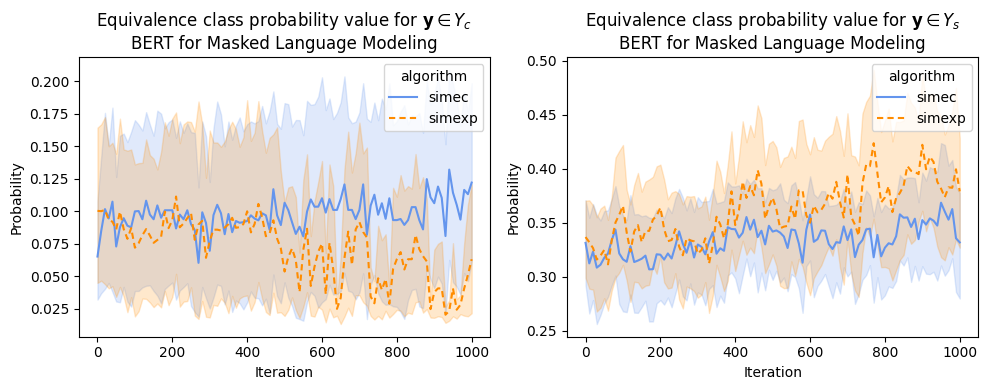

In [128]:
fig, ax = plt.subplots(figsize=(10, 4), ncols = 2)
sns.lineplot(data=data_msk.loc[data_msk["same-eq-class"] == False], ax=ax[0], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[0].set(ylabel='Probability', title = 'Equivalence class probability value for $\mathbf{y} \in Y_c$\nBERT for Masked Language Modeling', xlabel = "Iteration")
sns.lineplot(data=data_msk.loc[data_msk["same-eq-class"] == True], ax=ax[1], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[1].set(ylabel='Probability', title = 'Equivalence class probability value for $\mathbf{y} \in Y_s$\nBERT for Masked Language Modeling', xlabel = "Iteration")
plt.tight_layout()
plt.show()

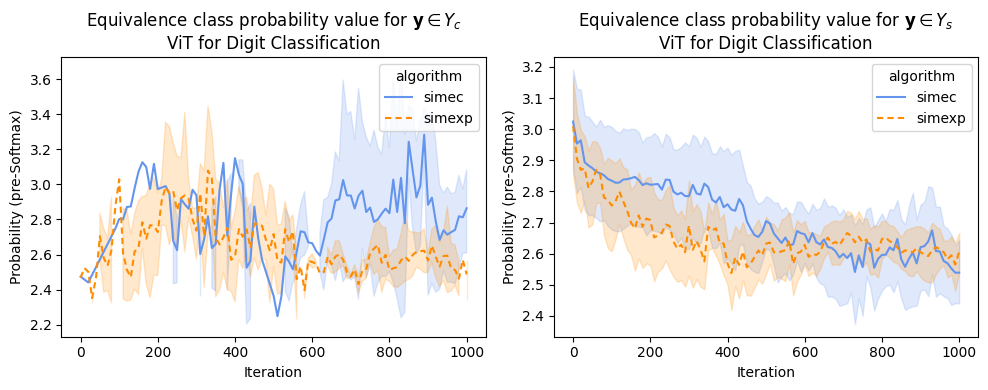

In [134]:
fig, ax = plt.subplots(figsize=(10, 4), ncols = 2)
sns.lineplot(data=data_vit.loc[data_vit["same-eq-class"] == False], ax=ax[0], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[0].set(ylabel='Probability (pre-Softmax)', title = 'Equivalence class probability value for $\mathbf{y} \in Y_c$\nViT for Digit Classification', xlabel = "Iteration")
sns.lineplot(data=data_vit.loc[data_vit["same-eq-class"] == True], ax=ax[1], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[1].set(ylabel='Probability (pre-Softmax)', title = 'Equivalence class probability value for $\mathbf{y} \in Y_s$\nViT for Digit Classification', xlabel = "Iteration")
plt.tight_layout()
plt.show()

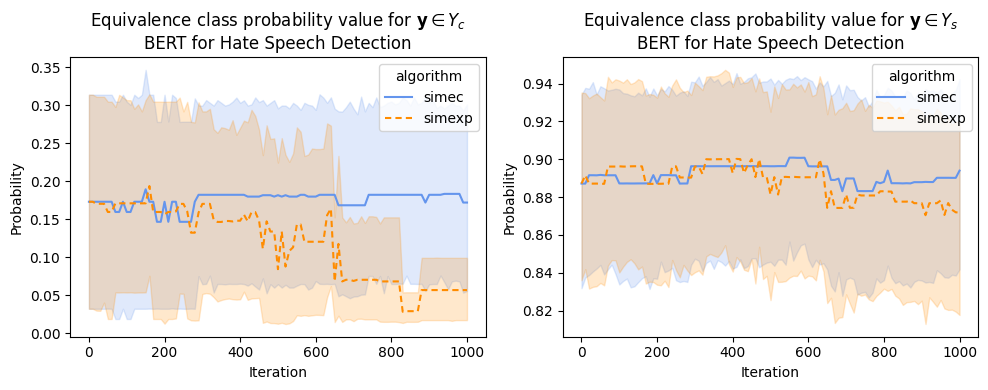

In [133]:
fig, ax = plt.subplots(figsize=(10, 4), ncols = 2)
sns.lineplot(data=data_cls.loc[data_cls["same-eq-class"] == False], ax=ax[0], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[0].set(ylabel='Probability', title = 'Equivalence class probability value for $\mathbf{y} \in Y_c$\nBERT for Hate Speech Detection', xlabel = "Iteration")
sns.lineplot(data=data_cls.loc[data_cls["same-eq-class"] == True], ax=ax[1], x = "iteration", y = "modified-pred-proba", style = "algorithm", hue = "algorithm", palette=palette, dashes=style)
ax[1].set(ylabel='Probability', title = 'Equivalence class probability value for $\mathbf{y} \in Y_s$\nBERT for Hate Speech Detection', xlabel = "Iteration")
plt.tight_layout()
plt.show()